## Домашнее задание<a class='anchor' id='hw'>

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [4]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg in trees_list:
            prediction += eta * alg.predict([x])[0]
        predictions[i] = prediction
        
#     predictions = np.array(
#         [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
#     )

    return predictions

In [5]:
def gb_predict_improved(X, tree, eta, prev_predictions):
    
    if not any(prev_predictions):
        for i, x in enumerate(X):
            prev_predictions[i] += eta * tree.predict([x])[0] 
    else:
        for i, x in enumerate(X):
            prev_predictions[i] += eta * tree.predict([x])[0]
    
    return prev_predictions

In [6]:
X_train.shape

(331, 10)

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [8]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

## №3

In [10]:
def gb_fit_improved(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    train_pred = np.zeros(X_train.shape[0])
    test_pred = np.zeros(X_test.shape[0])
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_pred = gb_predict_improved(X_train, tree, eta, train_pred)
            test_pred = gb_predict_improved(X_test, tree, eta, test_pred)
            
            train_errors.append(mean_squared_error(y_train, train_pred))
            test_errors.append(mean_squared_error(y_test, test_pred))
        else:
#             # Получим ответы на текущей композиции
#             target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, train_pred))
            
            train_pred = gb_predict_improved(X_train, tree, eta, train_pred)
            test_pred = gb_predict_improved(X_test, tree, eta, test_pred)          
            
            train_errors.append(mean_squared_error(y_train, train_pred))
            test_errors.append(mean_squared_error(y_test, test_pred))

        trees.append(tree)
        
    return trees, train_errors, test_errors

## №1

In [11]:
from itertools import product
eta = 0.1

n_trees_list = [1, 5, 25, 50]
max_depth_list = [3, 5, 10]

results_list = np.zeros([len([(x, y) for x, y in product(n_trees_list, max_depth_list)]), 3])
iterator = 0

for n_trees, max_depth in product(n_trees_list, max_depth_list):
    trees, _, _ = gb_fit_improved(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    
    test_prediction = gb_predict(X_test, trees, eta)
    
    results_list[iterator, :] = (n_trees, max_depth, mean_squared_error(y_test, test_prediction))
    
    iterator += 1

In [12]:
results_list

array([[1.00000000e+00, 3.00000000e+00, 2.14714009e+04],
       [1.00000000e+00, 5.00000000e+00, 2.14809792e+04],
       [1.00000000e+00, 1.00000000e+01, 2.14582103e+04],
       [5.00000000e+00, 3.00000000e+00, 1.02746418e+04],
       [5.00000000e+00, 5.00000000e+00, 1.00873599e+04],
       [5.00000000e+00, 1.00000000e+01, 1.04842563e+04],
       [2.50000000e+01, 3.00000000e+00, 2.85280308e+03],
       [2.50000000e+01, 5.00000000e+00, 3.04721237e+03],
       [2.50000000e+01, 1.00000000e+01, 4.39053483e+03],
       [5.00000000e+01, 3.00000000e+00, 2.88231570e+03],
       [5.00000000e+01, 5.00000000e+00, 3.21125318e+03],
       [5.00000000e+01, 1.00000000e+01, 4.73008848e+03]])

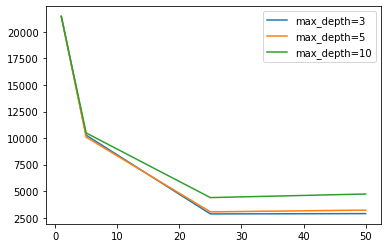

In [13]:

for max_depth in max_depth_list:
    plt.plot(results_list[np.where(results_list[:,1] == max_depth)][:,0], results_list[np.where(results_list[:,1] == max_depth)][:,2], label=f'max_depth={max_depth}')
    plt.xlabel = 'n_trees'
    plt.ylabel = 'MSE'
    plt.legend()

## №2

In [14]:
from random import sample

def stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, fraction=0.5):
    # Деревья будем записывать в список
    trees = []
    X_tr_len = X_train.shape[0]
    X_ts_len = X_test.shape[0]
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    train_pred = np.zeros(X_tr_len)
    test_pred = np.zeros(X_ts_len)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_pred = gb_predict_improved(X_train, tree, eta, train_pred)
            test_pred = gb_predict_improved(X_test, tree, eta, test_pred)
            
            train_errors.append(mean_squared_error(y_train, train_pred))
            test_errors.append(mean_squared_error(y_test, test_pred))
        else:
            sample_indexes = sample(range(X_tr_len), int(X_tr_len * fraction))
            X_train_part = X_train[sample_indexes, :]
            y_train_part = y_train[sample_indexes]
            train_pred_part = train_pred[sample_indexes]
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_part, residual(y_train_part, train_pred_part))
            
            train_pred = gb_predict_improved(X_train, tree, eta, train_pred)
            test_pred = gb_predict_improved(X_test, tree, eta, test_pred)          
            
            train_errors.append(mean_squared_error(y_train, train_pred))
            test_errors.append(mean_squared_error(y_test, test_pred))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [15]:
%%time
trees_imp, train_errors_imp, test_errors_imp = gb_fit_improved(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 1.32 s


In [16]:
%%time
trees_st, train_errors_st, test_errors_st = stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 1.31 s


In [17]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [18]:
%%time
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 49.9 s


In [19]:
%%time
eta = 0.1
max_depth = 5
n_trees = 50

trees_imp, train_errors_imp, test_errors_imp = gb_fit_improved(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 1.38 s


In [20]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees_imp, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 326.46846322391133
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3211.253176757588
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 326.46846322391133
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3211.253176757588


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [24]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel = 'Iteration number'
    plt.ylabel = 'MSE'
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

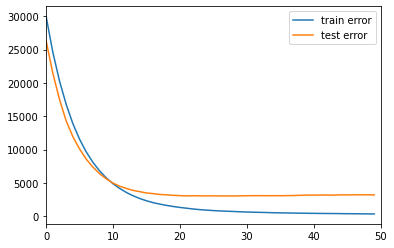

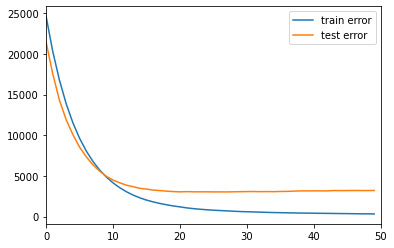

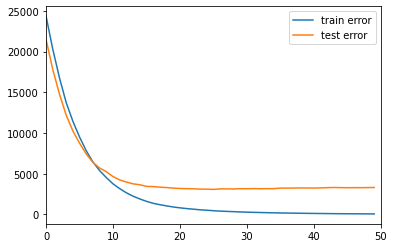

In [25]:
get_error_plot(n_trees, train_errors, test_errors)
get_error_plot(n_trees, train_errors_imp, test_errors_imp)
get_error_plot(n_trees, train_errors_st, test_errors_st)